# Delay Differential Equations with Python

Time delay systems are something which come up form time to time in a wide range of fields. Such systems are modeled using a special type of differential equations called <a href="https://en.wikipedia.org/wiki/Delay_differential_equation" target="_blank">delay differential equations</a>. Unlike normal ordinary differential equations, the derivative at a certain time in the future is given in terms of the function's values at past time steps.

In today's post, we numerically solve the delay difference equations (equations 10~12) proposed by <a href="http://www.eri.u-tokyo.ac.jp/people/ichihara/vp2008plan/NakanishiKoyaguchi2008.pdf" target="_blank">Nakanishi, M., Koyaguchi, T., A stability analysis of a conduit flow model for lava dome eruptions, Journal of Volcanology and Geothermal Research (2008)</a>, which models magmatic conduit flow inside a volcanic system. The system is essentially a two dimensional system: pressure _P_(_t_) and flux _Q_(_t_) within the conduit.

Depending on the internal conditions of the volcanc conduit, the flux _Q_(_t_) is governed by either equation 11 or 12. The pressure _P_(_t_) is always governed by equation 10.

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/Koyanagi_e1.png?raw=True" alt="drawing" width="500"/>

## Delay Differential Equations for a Volcanic System

As the proposed system is a delay difference equation, in addition to setting up the set of initial value differential equations to solve using numerical solvers such as the Runge-Kutta methods, we also need to create the historical time delay which will influence the solution in future time steps. Additionally, the particular form of the differential equation to be integrated at each time step also changes depending on certain conditions inside the volcanic conduit. Therefore at each time step we need to make a condition check and select the correct form of the differential equation to be solved by the numerical solver.

The Python code to solve equations 10~12 in the outlined in the <a href="http://www.eri.u-tokyo.ac.jp/people/ichihara/vp2008plan/NakanishiKoyaguchi2008.pdf" target="_blank">paper</a> is given below. The code first sets up the 2 different forms which the volcanic system can take, creates the delay difference history, and then solves the delay differential equation numerically by calling the correct form of the system based on the volcanic system's conditions. The final results for the integration time steps as well as the volcanic system's pressure and flux _P_(_t_) and _Q_(_t_) are returned at the end.

First, we implement `rk4`, which contains a fourth order <a href="https://en.wikipedia.org/wiki/Runge–Kutta_methods" target="_blank">Runge-Kutta</a> solver to numerically integrate the delay differential equation in time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# This code solves the delay difference equations proposed by:
# M. Nakanishi, T. Koyaguchi, "A stability analysis of a conduit flow model for lave dome eruptions",
# Journal of Volcanology and Geothermal Research, 178, 46-57, 2008.

def rk4(t0, t1, y0, ydot_fun, params, delayx):
    """
    Runge-Kutta-4 algorithm

    Inputs
    ------
    t0: float
        start of time step 
    t1: float
        end of time step
    y0: np.array
        DDE solution values at time step t0
    y_dot_fun: function
        function containing the DDE to integrate numerically
    params: np.array
        [Qin, mu] DDE parameters
    delayx: np.array
        DDE solution values at some previous time step
    Returns
    -------
    y1: np.array
        DDE solution values at time step t1
    """
    dt = t1 - t0
    k1 = dt * ydot_fun(y0, t0, params, delayx)
    k2 = dt * ydot_fun(y0 + 0.5 * k1, t0 + dt * 0.5, params, delayx)
    k3 = dt * ydot_fun(y0 + 0.5 * k2, t0 + dt * 0.5, params, delayx)
    k4 = dt * ydot_fun(y0 + k3, t0 + dt, params, delayx)
    
    return y0 + (k1 + 2 * k2 + 2 * k3 + k4) / 6.0

Next, we implement `less_than_one` and `more_than_one`, which contain the delay difference equations (equations 10~12 in the paper) to solve numerically. Either of these functions will be called directly by `rk4` for numerical integration.

When `np.trap(Q, T) <= 1`, where `Q` is the flux and `T` is time, equation 11 is used by `less_than_one` to solve for _Q_(_t_). On the other hand when `np.trap(Q, T) > 1`, equation 12 is used by `more_than_one` to solve for _Q_(_t_).

In [2]:
# The delay difference equations proposed by come in 2 different forms depending on the current system conditions. 

def less_than_one(x, t, params, delayx):
    """
    First set of DDE equations, when np.trapz(Q, T) <= 1

    Inputs
    ------
    x: np.array
        variables to integrate. P and Q in this system.
    t: float
        time 
    params: np.array
        [Qin, mu] DDE parameters
    delayx: np.array
        DDE function values at some previous time step
    Returns
    -------
    ydot: np.array
        np.array of DDE values
    """
    Qin = params[0]
    mu = params[1]
    ydot = np.zeros(len(x))
    ydot[0] = Qin - x[1] # pressure P
    ydot[1] = x[1] / x[0] * (Qin - x[1] + (mu - 1) * (x[1] - delayx) * x[1]) # flux Q
    
    return ydot.copy()

def more_than_one(x, t, params, delayx):
    """
    Second set of DDE equations, when np.trapz(Q, T) > 1

    Inputs
    ------
    x: np.array
        variables to integrate. P and Q in this system.
    t: float
        time step
    params: np.array
        [Qin, mu] DDE parameters
    delayx: np.array
        DDE solution values at some previous time step
    Returns
    -------
    ydot: np.array
        np.array of DDE values
    """
    Qin = params[0]
    ydot = np.zeros(len(x))
    ydot[0] = Qin - x[1] # pressure P
    ydot[1] = Qin - x[1] # flux Q
    
    return ydot.copy()

Finally, we implement the main driver function `lava_dome_conduit_flow`, which uses the functions implemented above to solve for the delay differential numerical solution for _P_(_t_) and _Q_(_t_).

In [3]:
def lava_dome_conduit_flow(Qin = 0.8, mu = 10, y0 = np.array([1.5, 1.5]), 
                           t_star = 1, dt = None, t_end = None,
                           less_than_one = None, more_than_one = None, rk4 = None):
    """
    Inputs
    ------
    Qin: float
        DDE parameter for input flux
    mu: float
        DDE parameter for magma viscosity
    y0: np.array
        initial conditions for [P, Q]
    t_star: float
        time parameter.
    dt: np.float
        time step size. If set to None, dt will be calculated automatically using dt = t_star / 20000
    t_end: float
        end time. If set to None, t_end will be set automatically to 30
    less_than_one: function
        function containing the 1st set of DDEs to integrate when np.trapz(Q, T) <= 1
    more_than_one: function
        function containing the 2nd set of DDEs to integrate when np.trapz(Q, T) > 1
    rk4: function
        function containing the numerical integration algorithm

    Returns
    -------
    t, Y: np.array
        np.arrays of time steps and corresponding integrated variables [P, Q]
    """
    
    if (less_than_one is None) or (more_than_one is None) or (rk4 is None):
        return

    if dt is None:
        dt = t_star / 20000 # set time step size
    if t_end is None:
        t_end = 30

    delayindex = int(t_star / dt) # set the delay (history) index
    params = np.array([Qin, mu])

    # length of time of the simulation
    t = np.arange(-t_star, t_end + dt, dt) 
    Y = np.zeros([len(t), len(y0)])
    
    # set initial conditions for the simulation
    Y[0, :] = y0.copy() 
    
    # Create delay difference history (history has length of delayindex)
    for i in range(delayindex):
        y0[0] = y0[0] - 1.0 / delayindex # pressure P history
        y0[1] = y0[1] - 1.0 / delayindex # flux Q history
        Y[i+1, :] = y0.copy()
    
    # Actual RK4 loop to solve the delay differential equation
    for i in range(len(t) - 1 - delayindex):
        delayx = Y[i, 1].copy()
        T = t[i:i + delayindex + 1].copy()
        Q = Y[i:i + delayindex + 1, 1].copy()
        QT = np.trapz(Q, T) # check the value of the integral of Q with respect to T
        if QT > 1:
            # if np.trapz(Q, T) > 1, the DDE equation to integrate is more_than_one
            Y[i+1+delayindex, :] = rk4(t[i+delayindex], t[i+1+delayindex], 
                                       Y[i+delayindex,:], more_than_one, params, delayx)
        else:
            # if np.trapz(Q, T) <= 1, the DDE equation to integrate is less_than_one
            Y[i+1+delayindex, :] = rk4(t[i+delayindex], t[i+1+delayindex], 
                                       Y[i+delayindex,:], less_than_one, params, delayx)

    # don't forget to remove the (artificial) history from the data!!!
    return (t[delayindex:].copy(), Y[delayindex:].copy())

Running the numerical solver for the default parameter values, and plotting the flux _Q_(_t_) against the pressure _P_(_t_) reveals that the volcanic system settles into a limit cycle, agreeing with Fig 2. in the <a href="https://www.eri.u-tokyo.ac.jp/people/ichihara/vp2008plan/NakanishiKoyaguchi2008.pdf" target="_blank">paper</a>. Although not as interesting as chaotic motion, limit cycles are extremely important as they govern the vast majority of periodic behaviour in the natural as well as man made world. For volcanic systems, limit cycles may be able to explain certain types of volcanic tremor or periodic seismic events.

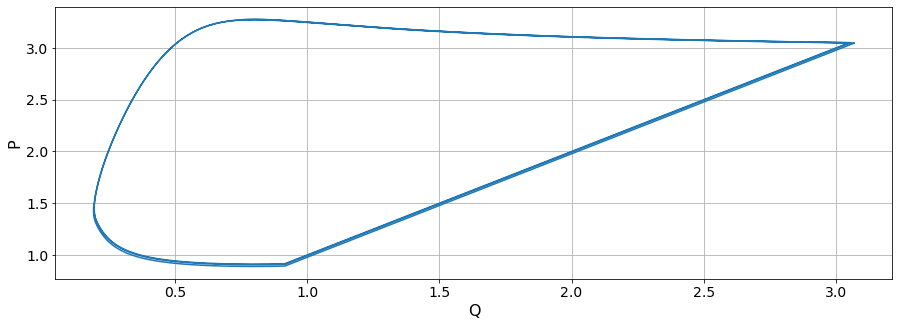

In [4]:
t, Y = lava_dome_conduit_flow(Qin = 0.8, mu = 10, y0 = np.array([1.5, 1.5]), 
                             t_star = 1, dt = None, t_end = None,
                             less_than_one = less_than_one, more_than_one = more_than_one, rk4 = rk4)

Q = Y[int(len(Y) * 0.2):, 1]
P = Y[int(len(Y) * 0.2):, 0]

plt.figure(figsize = (15, 5))
plt.plot(Q, P) 
plt.xlabel('Q', fontsize = 16)
plt.ylabel('P', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid('on')
plt.show() 